# Lab 5: Self-Supervised Contrastive Learning with SimCLR


Goal of the lecture:

1. Load the UCMerced dataset from the previous lab
1. Get a general understanding of self-supervised contrastive learning
1. Train SimCLR 
1. Evaluate the learned representations



## Import Packages

In [ ]:
## Standard libraries
import os
from copy import deepcopy
from typing import Tuple

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline


import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set_theme()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import Subset

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import numpy as np
import requests
from tqdm.notebook import tqdm
from pathlib import Path
import zipfile
from PIL import Image



# Import tensorboard
%load_ext tensorboard

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)


In [ ]:


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [ ]:
N_CLASSES = 21

class UCMerced(Dataset):
    def __init__(self, base_dir: Path, img_transform: transforms = None, image_only: bool = False):
        self.base_dir = base_dir
        self.download_dataset()
        self.images_path = base_dir / "UCMerced_LandUse/Images"
        self.class_names = sorted(
            [cl.name for cl in self.images_path.iterdir() if not cl.name.startswith(".")]
        )
        self.img_paths, self.targets = self.read_data()
        self.img_transform = img_transform
        self.image_only = image_only


    def download_dataset(self):
        ucmerced_path = self.base_dir / "UCMerced.zip"
        if not ucmerced_path.exists():
            print("Downloading UCMerced")
            download_file_with_progress(
                "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip",
                ucmerced_path,
            )
            zipf = zipfile.ZipFile(ucmerced_path)
            zipf.extractall(self.base_dir)

    def read_data(self):
        img_paths, targets = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = self.images_path / cl_name

            for img_path in sorted(cl_path.iterdir()):
                img_paths.append(img_path)
                targets.append(cl_id)

        return img_paths, targets


    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        target = self.targets[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.image_only:
            return img

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [ ]:
data_path = Path("./data")
CHECKPOINT_PATH = "./saved_models/lab5"
data_path.mkdir(exist_ok=True)
# For quick prototyping there is no such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

In [ ]:
full_dataset = UCMerced(data_path)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()

for i in range(4):
    idx = np.random.randint(low=0, high=2100)
    img, label = full_dataset[idx]
    axes[i].imshow(img)
    axes[i].set_title(full_dataset.class_names[label])
    axes[i].axis('off')


## Self-supervised contrastive learning

In this tutorial, we will take a closer look at self-supervised contrastive learning. **Self-supervised learning describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way**. However, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.


The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for earth observation, we can collect large amounts of data by simply downloading it from a satellite. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available. The subfield that we will focus on in this tutorial is contrastive learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="https://raw.githubusercontent.com/JonasKlotz/ipl4eo-dependencies/refs/heads/main/assets/simclr_contrastive_learning.png?raw=1" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. 
### Pretext Tasks and Downstream Applications
In self-supervised contrastive learning, we distinguish between:
- **Pretext Tasks** (pretraining), and
- **Downstream Tasks** (final task).




<center width="50%"><img src="https://raw.githubusercontent.com/JonasKlotz/ipl4eo-dependencies/refs/heads/main/assets/pretext_vs_downstream.png" width="500px"></center>

(figure credit - [Wang et al.](https://ieeexplore.ieee.org/abstract/document/9875399)):

---

### Lab Question

What could be possible pretext and downstream tasks in RS?


---


#### Sample Answer


## Data Augmentation for Contrastive Learning
We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such. 

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [ ]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Wang et al.](https://ieeexplore.ieee.org/abstract/document/9875399)):

<center width="100%">
  <img
    src="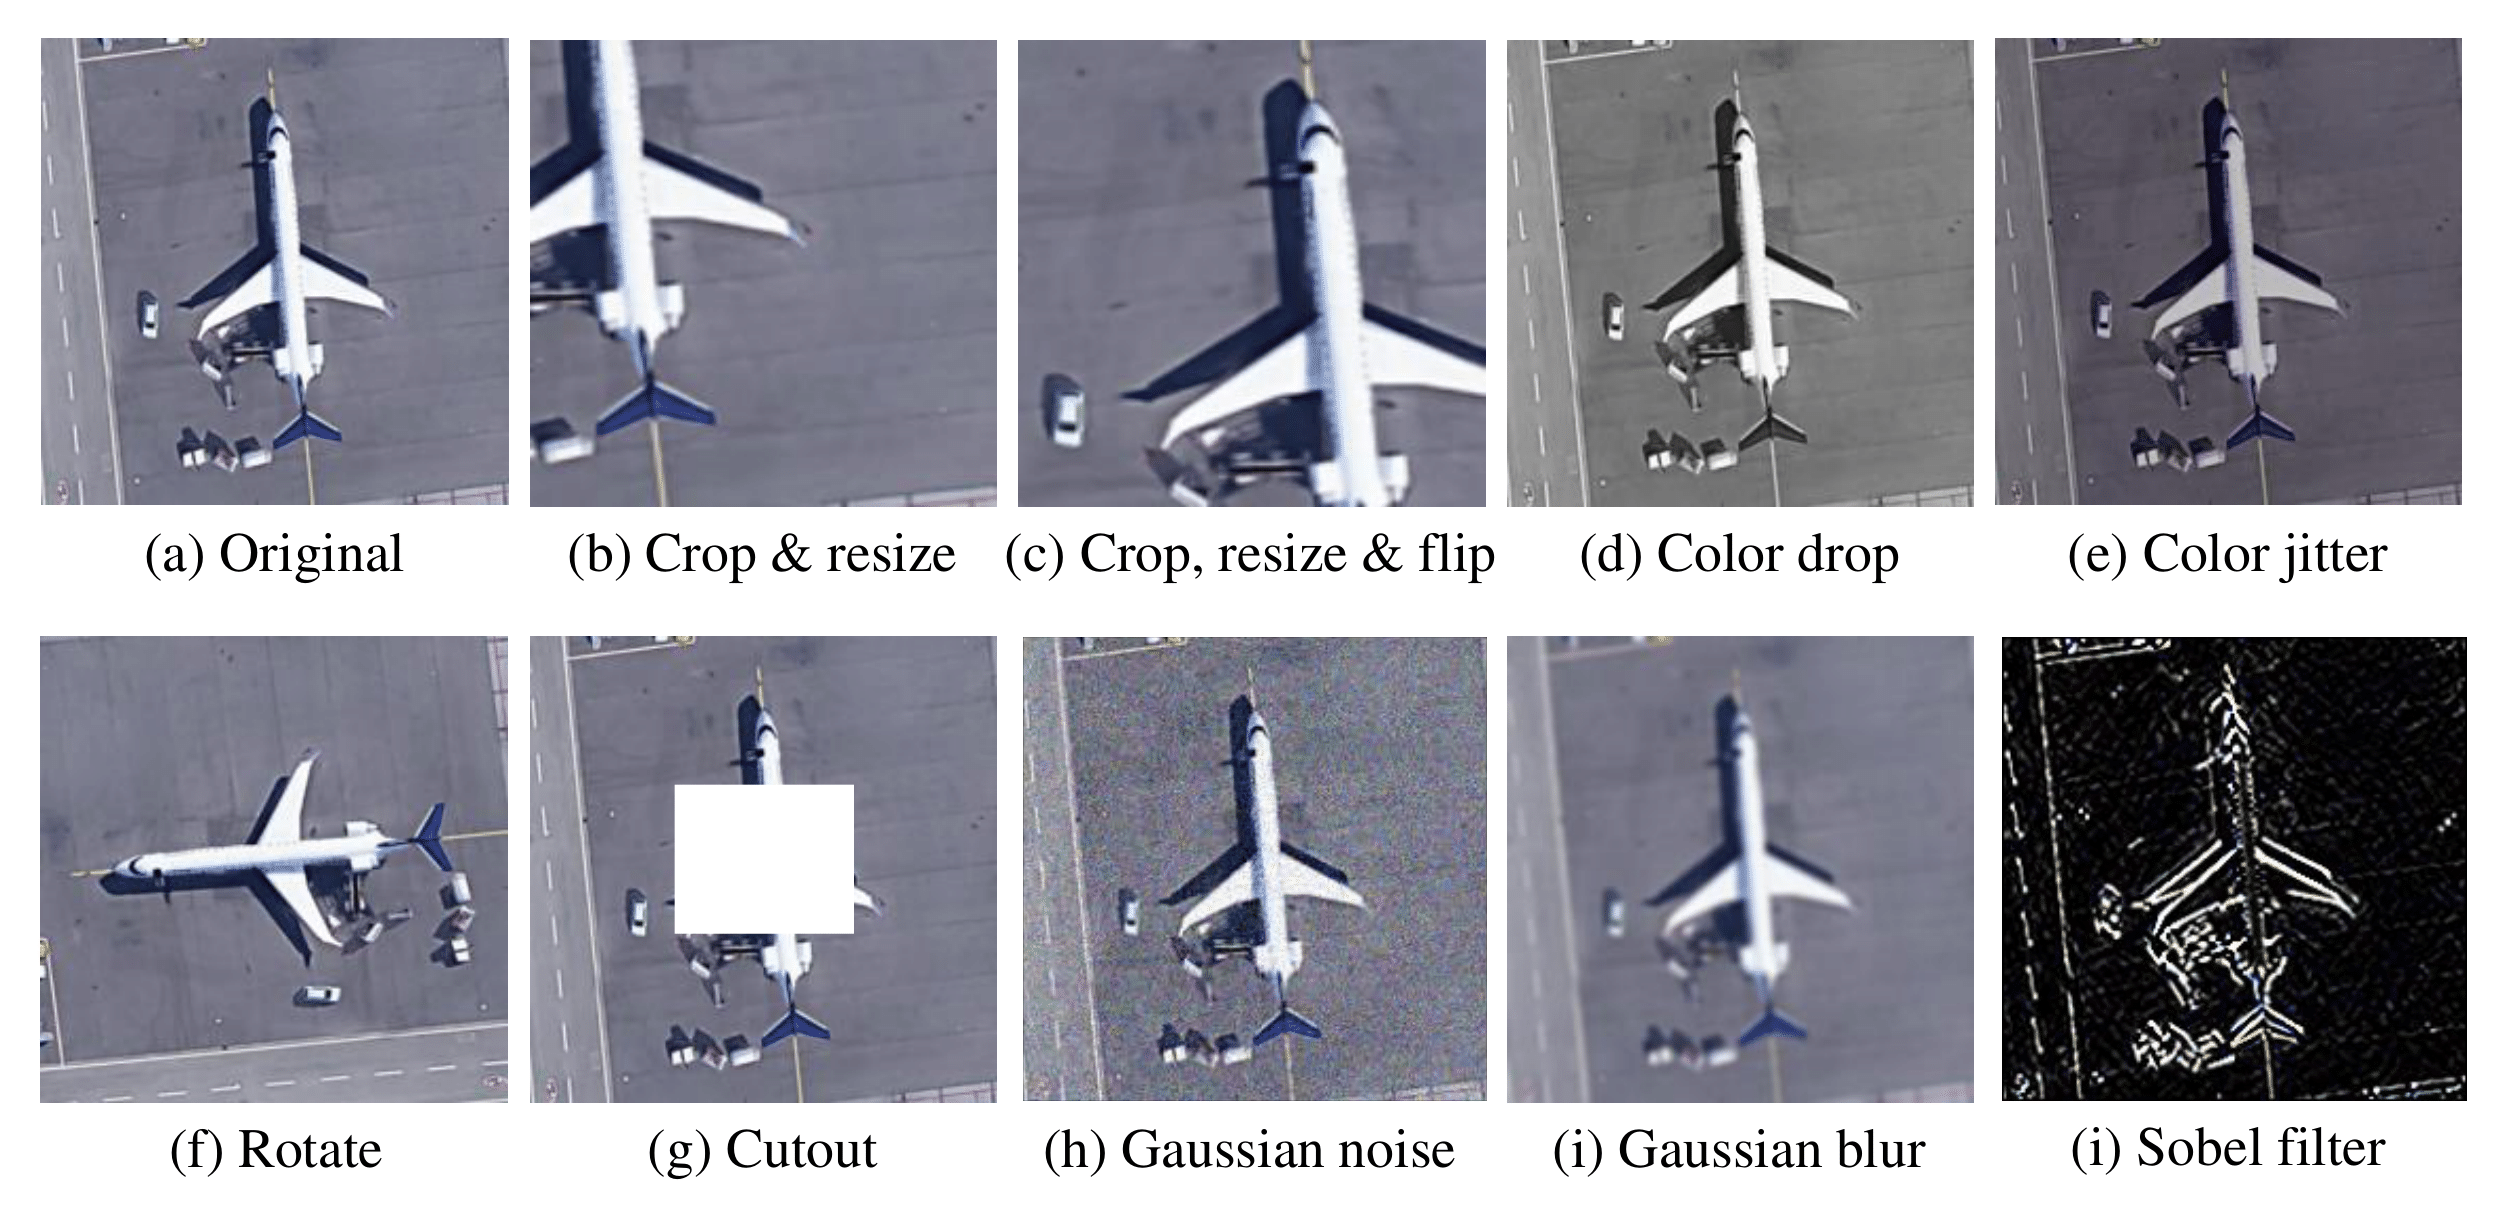
"
    width="800px"               
    style="padding-top:20px; padding-bottom:0;"
  >
</center>



All of them can be used, but it turns out that two augmentations stand out in their importance for natural images: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://raw.githubusercontent.com/JonasKlotz/ipl4eo-dependencies/refs/heads/main/assets/crop_views.png" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>




While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features.

If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.


## Augmentations for Multispectral Remote-Sensing Data

Remote-sensing imagery, however, has unique properties compared to antural images that constrain which transformations preserve physical and geospatial integrity.

---

### Lab Question

Which augmentations would you **would apply** and **avoid** when training a contrastive model on multispectral data?

---

### Sample Answer


#### Transformations

In [ ]:
# mean+std precomputed on whole dataset
ucm_mean = [0.595425, 0.3518577, 0.3225522]  
ucm_std = [0.19303136, 0.12492529, 0.10577361]

tr_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)), # only for efficiency usually larger = better
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)



As in the last Lab we will use `torchvision.transforms` for the transformations.

---

### Lab Task 


Build a transformation pipeline for contrastive learning for RS images.

---

In [ ]:
# RS‐contrastive pipeline
contrast_transforms_rs = ...

#### Load datasets


In [ ]:
from sklearn.model_selection import train_test_split

def get_split_idx(targets: np.array, train_size: float, val_size: float, test_size: float):
    assert train_size + val_size + test_size == 1
    relative_val_size = val_size / (1 - test_size)
    full_idx = np.arange(0, len(targets))
    train_val_idx, test_idx, y_trainval, y_test = train_test_split(
        full_idx, targets, test_size=test_size, stratify=targets
    )
    train_idx, val_idx, y_train, y_val = train_test_split(
        train_val_idx, y_trainval, test_size=relative_val_size, stratify=y_trainval
    )
    return train_idx, val_idx, test_idx


def get_contrastive_splits(
    data_path: str,
    contrast_transforms: torchvision.transforms.Compose,
    te_transform: torchvision.transforms.Compose,
    train_size: float = 0.5,
    val_size: float   = 0.2,
    test_size: float  = 0.3,
    n_views: int      = 2
) -> Tuple[Subset, Subset, Subset]:
    """
    Instantiate UCMerced datasets with contrastive and test transforms,
    split into train/val/test subsets, and return the three Subsets.

    Args:
        data_path (str): Path to the root of the UCMerced dataset.
        contrast_transforms (Compose): Transformations for contrastive pre-training.
        te_transform (Compose): Transformations for evaluation (single view).
        train_size (float): Fraction of samples for training.
        val_size (float): Fraction of samples for validation.
        test_size (float): Fraction of samples for testing.
        n_views (int): Number of augmented views per sample for contrastive learning.

    Returns:
        train_dataset (Subset): Training split with contrastive views.
        val_dataset   (Subset): Validation split with contrastive views.
        test_dataset  (Subset): Testing split with single-view transform.
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1."

    # Load a dummy dataset only to retrieve targets for stratified split
    full_dataset = UCMerced(data_path, img_transform=None)
    train_idx, val_idx, test_idx = get_split_idx(
        full_dataset.targets, train_size, val_size, test_size
    )

    # Instantiate full contrastive and test datasets
    full_tr = UCMerced(
        data_path,
        img_transform=ContrastiveTransformations(contrast_transforms, n_views=n_views)
    )
    full_te = UCMerced(
        data_path,
        img_transform=te_transform
    )

    # Wrap subsets
    train_dataset = Subset(full_tr, train_idx)
    val_dataset   = Subset(full_tr, val_idx)
    test_dataset  = Subset(full_te, test_idx)

    total = len(full_dataset.targets)
    print(f"Train: {len(train_idx)} ({len(train_idx)/total*100:.1f}%)  "
          f"Val: {len(val_idx)} ({len(val_idx)/total*100:.1f}%)  "
          f"Test: {len(test_idx)} ({len(test_idx)/total*100:.1f}%)")

    return train_dataset, val_dataset, test_dataset, train_idx, val_idx, test_idx



In [ ]:
train_dataset_contrastive, val_dataset_contrastive, test_ds, train_idx, val_idx, test_idx = get_contrastive_splits(
    data_path=data_path,
    contrast_transforms=contrast_transforms_rs,
    te_transform=te_transform,
    train_size=0.5,
    val_size=0.2,
    test_size=0.3,
    n_views=2
)

Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

In [ ]:
pl.seed_everything(42)
n_image_pairs = 6
# Create a list of image pairs
image_pairs = []
for i in range(n_image_pairs):
    image_pairs.extend(train_dataset_contrastive[i][0])

img_grid = torchvision.utils.make_grid(image_pairs, nrow=n_image_pairs, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image pairs of the UCMerced dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


In [ ]:
def sample_contrastive_batch(dataset, n_image_pairs):
    view1_list = []
    view2_list = []

    for idx in range(n_image_pairs):
        (view1, view2), _ = dataset[idx]
        view1_list.append(view1)
        view2_list.append(view2)

    view1_batch = torch.stack(view1_list, dim=0)  # (B, C, H, W)
    view2_batch = torch.stack(view2_list, dim=0)  # (B, C, H, W)

    return (view1_batch, view2_batch), None


### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. **At each iteration, we get for every image $x$ two differently augmented versions**, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen in the previous Lab before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. 

Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://raw.githubusercontent.com/JonasKlotz/ipl4eo-dependencies/refs/heads/main/assets/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

We will use the second one in the loss. The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

**Why do we need the negative samples?**

Now we sample a small batch to help us understand the calculation of the nce_loss:

In [ ]:
batch = sample_contrastive_batch(train_dataset_contrastive, 2)
(view1_batch, view2_batch), _ = batch
imgs = torch.cat([view1_batch, view2_batch], dim=0)  # (2B, C, H, W)
imgs.shape

4 Stacked images, imgs[0] and imgs[1] are original, imgs[2] and imgs[3] are contrastive views

Encode them with a toy encoder

In [ ]:
simple_encoder = torchvision.models.resnet18(num_classes=4*128)  
feats = simple_encoder(imgs)  # (2B, D)
feats.shape

### Breakdown of the formula

$$
\ell_{i,j}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

1. Feature vectors: two augmented versions of the same image, i.e., $z_i$ and $z_j$; rest of the batch $z_k$
2. Similarity computation: $\text{sim}(z_i,z_k)$ 
3. Temperature scaling: $\text{sim}(z_i,z_k)/\tau$
4. Masking self-similarities: $\mathbb{1}_{[k\neq i]}$
5. Positive similarity term: $\text{sim}(z_i,z_j)/\tau$
6. Sum over negatives: $\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]$
7. Full per-sample loss

**Summary:**
First, we encode all images into feature vectors. Then, we measure how similar each feature is to every other one using cosine similarity. We divide these similarities by a small temperature to make the differences clearer. We ignore the similarity of a feature to itself. For each feature, we want the similarity to its correct paired feature (the positive) to be much higher than to any other feature. So we compute the difference between the positive similarity and the total similarity to all others, and then average this over the whole batch to get the final loss.

In [ ]:
cos_sim = 
cos_sim
# which pairs belong together as self-similarities and positives

In [ ]:
temperature=0.07 #  Small τ (like 0.07) = Sharper softmax, stronger contrast between positives and negatives.
cos_sim = cos_sim / temperature
cos_sim

In [ ]:
# How can we mask the self-similarities? Can we somehow use the `exp` function to remove their impact from the sum?


In [ ]:
# Create positive mask (positive pairs are half the batch apart) 
pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
print(pos_mask)
-cos_sim[pos_mask] 
# Picks out only the positive pairs (the matching augmented views) and negates their similarity.

In [ ]:
# Calc the log sum of the exponents (e.g. with torch.logsumexp) # last dim


In [ ]:
nll = 
loss = nll.mean()
nll, loss

In [ ]:
def compute_info_nce_loss_from_feats(feats, temperature=0.07):
    """
    Computes the InfoNCE loss and evaluation metrics from precomputed feature representations.

    Args:
        feats (Tensor): Encoded feature vectors of shape (2B, D), where 2B is the number of augmented views.
        temperature (float): Temperature parameter for scaling cosine similarities.

    Returns:
        Tuple[torch.Tensor, dict]: 
            - Scalar InfoNCE loss (torch.Tensor).
            - Dictionary with keys: 'acc_top1', 'acc_top5', 'acc_mean_pos'.
    """
    nll = ...
    loss = nll.mean()

    # Compute ranking metrics
    comb_sim = torch.cat([
        cos_sim[pos_mask][:, None],  # Positive example first
        cos_sim.masked_fill(pos_mask, -9e15)
    ], dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    metrics = {
        'acc_top1': (sim_argsort == 0).float().mean(),
        'acc_top5': (sim_argsort < 5).float().mean(),
        'acc_mean_pos': 1 + sim_argsort.float().mean()
    }

    return loss, metrics


Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch  # imgs = (view1, view2)
        imgs = torch.cat(imgs, dim=0)  # (2B, C, H, W)
    
        feats = self.convnet(imgs)  # (2B, D)
    
        loss, metrics = compute_info_nce_loss_from_feats(
            feats=feats,
            temperature=self.hparams.temperature
        )
    
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc_top1', metrics['acc_top1'])
        self.log(f'{mode}_acc_top5', metrics['acc_top5'])
        self.log(f'{mode}_acc_mean_pos', metrics['acc_mean_pos'])
    
        return loss


    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='val')

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that. 

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [ ]:
def train_simclr(batch_size, max_epochs=500,load_pretrained=True,  **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         log_every_n_steps=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    print(pretrained_filename)
    if os.path.isfile(pretrained_filename) and load_pretrained:
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(train_dataset_contrastive, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(val_dataset_contrastive, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        print(f"Finished Training, model loaded from {trainer.checkpoint_callback.best_model_path}")

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. As we are using a toy dataset we experienced that a batch size of 256 was sufficient to get good results.

In [ ]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=25,
                            load_pretrained=True)

## Evaluation of Learned Representations

After self-supervised contrastive pre-training, we must assess how well the encoder $f(\cdot)$ has captured useful features. Three common evaluation protocols are:


In [ ]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of UCMerced. The training set contains 1049 images, while the test set has 630 images.

In [ ]:
# instatiate one full dataset with train transformation and one with test transformation
full_dataset_tr = UCMerced(data_path, img_transform=tr_transform)
full_dataset_te = UCMerced(data_path, img_transform=te_transform)

from torch.utils.data import Subset

train_dataset = Subset(full_dataset_tr, train_idx)

val_dataset = Subset(full_dataset_tr, val_idx)

test_dataset = Subset(full_dataset_te, test_idx)


In [ ]:
train_img_data = train_dataset
test_img_data = test_dataset

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

## Visualizing the Representation Space with UMAP

Below we project the high-dimensional SimCLR features into 2D using UMAP and color each point by its ground-truth class.



In [ ]:
import torch
import matplotlib.pyplot as plt
import umap
import numpy as np
from matplotlib.cm import get_cmap

# Extract tensors from the TensorDataset
features_tensor, labels_tensor = train_feats_simclr.tensors
features = features_tensor.numpy()
labels = labels_tensor.numpy()

# Fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(features)

# Prepare discrete colormap
unique_labels = np.unique(labels)
cmap = get_cmap('tab10' if len(unique_labels) <= 10 else 'tab20')
colors = [cmap(i) for i in range(len(unique_labels))]

# Plot
plt.figure(figsize=(8, 8))
for i, label in enumerate(unique_labels):
    idx = labels == label
    class_name = full_dataset.class_names[label]  # Use dataset-provided class name
    plt.scatter(embedding[idx, 0], embedding[idx, 1],
                label=class_name, color=colors[i], s=5, alpha=0.8)

plt.title("UMAP of SimCLR Features (Labeled by Class)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(markerscale=4, fontsize=8, loc='best')
plt.tight_layout()
plt.show()


Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

We will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 0.2,0.4, 0.6, 0.8, 1 percent of the data. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [ ]:
def get_pct_subset(dataset, pct: float):
    """
    Return a random Subset containing ~pct of the original samples.
    """
    N = len(dataset)
    k = int(N * pct)
    idx = torch.randperm(N)[:k]
    return Subset(dataset, idx)


Next, let's run all models. Despite us training 5 models, this cell could be run within a minute or two without the pretrained models.

In [ ]:
results = {}
for num_imgs_per_label in [0.2,0.4, 0.6, 0.8, 1]:
    sub_train_set =  get_pct_subset(train_feats_simclr, num_imgs_per_label)

    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=N_CLASSES,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

Finally, let's plot the results.

In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]


fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("UCMerced classification over dataset size", fontsize=14)
plt.xlabel("Number of images ")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):

    print(f'Test accuracy for {k*100} % of images : {100*score:4.2f}%')

---
This tutorial was inspired by this notebook
[Credit](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html) 

---